In [1]:
# Importing libs
import re
import nltk
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef
from tqdm.notebook import trange

In [2]:
# Setting up default seeds
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device = gpu
device = torch.device("cuda")

In [3]:
# Collecting all the data, encoding emotion labels
df_test = pd.read_table('./emotion_dataset/test.txt', delimiter=';', names=['sentence','label'])
df_train = pd.read_table('./emotion_dataset/train.txt', delimiter=';', names=['sentence','label'])
df_val = pd.read_table('./emotion_dataset/val.txt', delimiter=';', names=['sentence','label'])
df = pd.concat([df_train,df_test,df_val])
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])
df.rename(columns={'label':'label_desc','label_enc':'label'},inplace=True)
df

,sentence,label_desc,label
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0
...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,4
1996,i constantly worry about their fight against n...,joy,2
1997,i feel its important to share this info for th...,joy,2
1998,i truly feel that if you are passionate enough...,joy,2


In [4]:
# How do they encoded
df[['label_desc','label']].drop_duplicates(keep='first')

,label_desc,label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [5]:
# How much samples for each emotion
df.label_desc.value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label_desc, dtype: int64

In [6]:
# Sentences list
sentences = df.sentence.values

# Importing BERT tokenizer, tokinizing sentences
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, pad_to_max_length=True) for sent in sentences]
labels = df.label.values

# Create an attention mask: 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
# Split into a training set and a test set
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=SEED, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=SEED, test_size=0.1)

In [15]:
# Converting into torch tensors
train_inputs = torch.tensor(train_inputs).type(torch.LongTensor)
validation_inputs = torch.tensor(validation_inputs).type(torch.LongTensor)
train_labels = torch.tensor(train_labels).type(torch.LongTensor)
validation_labels = torch.tensor(validation_labels).type(torch.LongTensor)
train_masks = torch.tensor(train_masks).type(torch.LongTensor)
validation_masks = torch.tensor(validation_masks).type(torch.LongTensor)

# Select a batch size
batch_size = 16

# Create an iterator of our data with torch DataLoader, its really heavy for memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [17]:
# Load the pretrained BERT model with a single linear classification layer on top
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6).to(device)

# Parameters
lr = 2e-5
adam_epsilon = 1e-8
epochs = 5
num_warmup_steps = 0
num_training_steps = len(train_dataloader) * epochs

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
# Loss and accuracy lists
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

for epoch_n in trange(1, epochs+1, desc='Epoch'):
  print("Epoch: " + str(epoch_n) + "/" + str(epochs))

  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    # Backward pass
    loss.backward()
    
    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()
    
    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print('Current Learning rate:', param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print('Average Training loss:', avg_train_loss)
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print('Validation Accuracy:', eval_accuracy/nb_eval_steps)
  print('Validation MCC Accuracy:', eval_mcc_accuracy/nb_eval_steps,'\n')

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Current Learning rate: 1.6000000000000003e-05
Average Training loss: 0.32880924785985716
Validation Accuracy: 0.94
Validation MCC Accuracy: 0.9219738588209456 

Epoch: 2/5
Current Learning rate: 1.2e-05
Average Training loss: 0.12358999280766067
Validation Accuracy: 0.936
Validation MCC Accuracy: 0.9151770955517914 

Epoch: 3/5
Current Learning rate: 8.000000000000001e-06
Average Training loss: 0.09267675857121746
Validation Accuracy: 0.9435
Validation MCC Accuracy: 0.9270282879296582 

Epoch: 4/5
Current Learning rate: 4.000000000000001e-06
Average Training loss: 0.07011680623573355
Validation Accuracy: 0.94
Validation MCC Accuracy: 0.9214847471024027 

Epoch: 5/5
Current Learning rate: 0.0
Average Training loss: 0.048532570524011845
Validation Accuracy: 0.938
Validation MCC Accuracy: 0.9186534857797966 



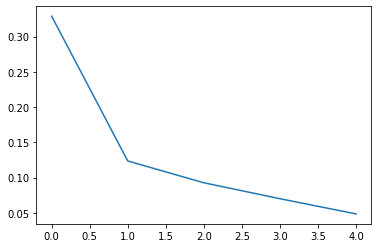

In [38]:
plt.plot(train_loss_set)

In [39]:
# Saving model and tokenizer just in case
model.save_pretrained('./mymodel/model/')
tokenizer.save_pretrained('./mymodel/tokenizer/')

# Most importantly, save trained model.state_dict
torch.save(model.state_dict(), './mymodel/trained_model.pt')

In [7]:
# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6).to(device)
model.load_state_dict(torch.load('./mymodel/trained_model.pt'))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
# Load our data
dtf = pd.read_json('data.json', lines=True)

stopwords = nltk.corpus.stopwords.words("english")

# Text preprocessing
def preprocess_text(text, stemm=False, lemm=True, stopwords=None):
    # Remove punctuations, lowercase, strip
    text = re.sub('_', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # Tokenize
    texts = text.split()    
    # Remove Stopwords
    if stopwords is not None:
        texts = [word for word in texts if word not in stopwords]
                
    # Stemming
    if stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        texts = [ps.stem(word) for word in texts]
                
    # Lemmatisation
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        texts = [lem.lemmatize(word) for word in texts]
            
    # Collect lists
    text = " ".join(texts)
    return text

dtf['comment_1_clear'] = dtf["comment_1"].apply(lambda x: preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
dtf['comment_2_clear'] = dtf["comment_2"].apply(lambda x: preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
dtf['comment_3_clear'] = dtf["comment_3"].apply(lambda x: preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
dtf = dtf[['comment_1_clear','comment_2_clear','comment_3_clear']]
dtf

,comment_1_clear,comment_2_clear,comment_3_clear
0,robinhood move goalpost didnt like score preve...,class action lawsuit filed government supposed...,basically robinhood stated account real benefi...
1,please please please let happen world insane w...,u trademark law first use first file long u go...,sound silly year ago uk police tried challenge...
2,penalty attempted suicide death,daily beating continue morale improves,understood said anyone look employment elsewhe...
3,hey guy youre please shut u could use nice men...,750 million people europe even zucky wont give...,much agree politician say life would good with...
4,ill take shit never thought would headline 800,tide pod challenge white house edition,got letter georgia congressman saying need hol...
...,...,...,...
9897,criterion bot use determine post,somewhat offtopic find interesting there resta...,taliban realise western civilisation isnt bad ...
9898,dont know company actually enough market power...,appears using shortterm view inflate severity ...,fta merger merger jones said really gotten poi...
9899,seems like pretty minor indictment even prosec...,look like legal document included report ill r...,im bot factual credibility grade selected pers...
9900,mod please let know need include source commen...,guardian articlehttpswwwtheguardiancomsport202...,interesting unsure science behind would settin...


In [15]:
# Prepare our data to feed it to the model
batch_size = 16
MAX_LEN = 128

# dtf.comment_1_clear.values is changed for comment_2_clear and comment_3_clear
input_comms_1 = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, pad_to_max_length=True) for sent in dtf.comment_1_clear.values]
input_comms_1 = torch.tensor(input_comms_1).type(torch.LongTensor)
att_masks_comms_1 = [[float(i>0) for i in seq] for seq in input_comms_1]
att_masks_comms_1 = torch.tensor(att_masks_comms_1).type(torch.LongTensor)

input_1 = TensorDataset(input_comms_1, att_masks_comms_1)
input_1_dataloader = DataLoader(input_1, shuffle=False, batch_size=batch_size)

c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
# Feeding data to our model to get predictions
results = []
for step, batch in enumerate(input_1_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    results.append(output.logits.softmax(dim=-1).tolist())

In [17]:
# Same done for c2,c3
c1 = []
for a in results:
    for b in a:
        c1.append(b.index(max(b)))

In [18]:
# int to label dict
int_to_label = {
  4: "sadness",
  2: "joy",
  0: "anger",
  1: "fear",
  5: "surprise",
  3: "love"
}

In [19]:
# Creating a result dataframe
emotions_df = pd.DataFrame()
emotions_df['enc_emote_c1'] = c1
emotions_df['enc_emote_c2'] = c2
emotions_df['enc_emote_c3'] = c3
emotions_df['emote_c1'] = list(map(lambda x: int_to_label[x], c1))
emotions_df['emote_c2'] = list(map(lambda x: int_to_label[x], c2))
emotions_df['emote_c3'] = list(map(lambda x: int_to_label[x], c3))

In [20]:
emotions_df

,enc_emote_c1,enc_emote_c2,enc_emote_c3,emote_c1,emote_c2,emote_c3
0,0,0,0,anger,anger,anger
1,0,4,0,anger,sadness,anger
2,1,2,4,fear,joy,sadness
3,2,0,2,joy,anger,joy
4,0,0,0,anger,anger,anger
...,...,...,...,...,...,...
9897,0,2,2,anger,joy,joy
9898,0,4,2,anger,sadness,joy
9899,2,0,2,joy,anger,joy
9900,2,0,0,joy,anger,anger


In [21]:
# Saving results
emotions_df.to_csv('emotions_df.csv', index=False)